In [1]:
using Plots, StatsPlots
include("src/SFGP_regression-learnable.jl")
using Flux
using StatsBase
using CSV, DataFrames
using ScikitLearn
using KnetMetrics
using Tables

In [2]:
df = Matrix(CSV.File("./data/winequality-white.csv") |> DataFrame)
X = Matrix(transpose(df[:,1:end-1]))
y = Matrix(transpose(df[:,end:end]))


1×4898 Matrix{Float64}:
 6.0  6.0  6.0  6.0  6.0  6.0  6.0  6.0  …  6.0  5.0  6.0  5.0  6.0  7.0  6.0

In [3]:
function getLoglike(mm::SFGP,X,y)
    
    m,S = mm.gp(X)
    s = Matrix(transpose(sqrt.(diag(S))[:,:]))
    
    probs = getProbs.(m,s,mm.lower,mm.upper)
    vals = (mm.vals) 
    

    return mean(logpdf.([MixtureModel(Normal.(vals,abs(mm.s[1,1])),p) for p in Flux.unstack(probs,2)],y[:]))
end


function getRMSE(mm::SFGP,X,y)
    
    m,S = mm.gp(X)
    s = Matrix(transpose(sqrt.(diag(S))[:,:]))
    
    probs = getProbs.(m,s,mm.lower,mm.upper)
    vals = (mm.vals) 
    
    
    return sqrt.(mean(((sum(probs.*vals,dims=1).-y).^2)))
    
end

getRMSE (generic function with 1 method)

In [4]:
import Random
Random.seed!(321)

folds = ScikitLearn.CrossValidation.KFold(size(X,2),n_folds=10)

lls = []
rmses = []
i = 0

for (train, test) in folds

    Xm = mean(X,dims=2)
    Xs = std(X,dims=2)
    sfgp = SFGP(SVGP((X[:,1:10] .- Xm)./Xs),20,3)
    
    params = Flux.params(sfgp)
    opt = ADAM(0.05)
    
    Xtrain = X[:,train]
    
    mean_train = mean(Xtrain,dims=2)
    std_train = std(Xtrain,dims=2)
    Xtrain = (Xtrain.-mean_train) ./ std_train
    
    Xtest = X[:,test]
    Xtest = (Xtest.-mean_train) ./ std_train
    
    ytrain = y[:,train]
    ytest = y[:,test]
    mean_ytrain = mean(ytrain)
    std_ytrain = std(ytrain)
    ytrain = (ytrain.-mean_ytrain)./std_ytrain
    ytest = (ytest.-mean_ytrain)./std_ytrain
    
    for i in 1:350
        grads = Zygote.gradient(() -> sample_elbo(sfgp,Xtrain,ytrain),params)
        Flux.Optimise.update!(opt,params,grads)
    end
    
    push!(lls, getLoglike(sfgp,Xtest,ytest))
    push!(rmses, getRMSE(sfgp,Xtest,ytest))
    
    i = i+1
    println(i)
end

1
2
3
4
5
6
7
8
9
10


In [5]:
println(mean(lls))
println(std(lls))

-1.2369048411646704
0.08273622842689975


In [6]:
println(mean((rmses)))
println(std((rmses)))

0.8319113381141762
0.07112636460036761


In [7]:
df = DataFrame(hcat(lls,rmses),[:loglike,:rmse])
CSV.write("./evals/sfgp_learnable_regression_winewhite.csv",  df)

"./evals/sfgp_learnable_regression_winewhite.csv"

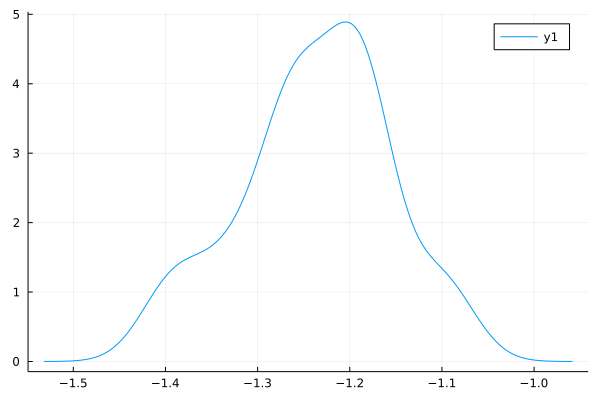

In [8]:
density(lls)